# Mount com o Drive

In [304]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Configuracao do Spark

In [305]:
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
# Download Spark
!wget -q https://dlcdn.apache.org/spark/spark-3.3.2/spark-3.3.2-bin-hadoop3.tgz
# Unzip the file
!tar xf spark-3.3.2-bin-hadoop3.tgz

In [306]:
import os

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = '/content/spark-3.3.2-bin-hadoop3'
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages io.delta:delta-core_2.12:2.1.0 --conf spark.sql.extensions=io.delta.sql.DeltaSparkSessionExtension --conf spark.sql.catalog.spark_catalog=org.apache.spark.sql.delta.catalog.DeltaCatalog pyspark-shell'

In [307]:
# Install library for finding Spark
!pip install -q findspark
# Import the libary
import findspark
# Initiate findspark
findspark.init()
# Check the location for Spark
findspark.find()

'/content/spark-3.3.2-bin-hadoop3'

In [308]:
def install_java():
  !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null      #install openjdk
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"     #set environment variable
  !java -version       #check java version
install_java()

openjdk version "11.0.19" 2023-04-18
OpenJDK Runtime Environment (build 11.0.19+7-post-Ubuntu-0ubuntu120.04.1)
OpenJDK 64-Bit Server VM (build 11.0.19+7-post-Ubuntu-0ubuntu120.04.1, mixed mode, sharing)


In [309]:

from pyspark.sql import SparkSession
from pyspark.sql.functions import *
spark = SparkSession.builder.appName('delta_session').getOrCreate()

In [310]:
# Bibliotecas pyspark
from pyspark.sql import SparkSession,SQLContext
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql.window import Window
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Definição dos Parametros

In [351]:
#entrada
path_rais =  f'/content/drive/MyDrive/Case_Senai/bases/rais.csv'
path_cnae_ben =  f'/content/drive/MyDrive/Case_Senai/bases/cnae_ben.csv'


# saida
path_cbo_top_outliers = f'/content/drive/MyDrive/Case_Senai/Output'


# Carregamento das bases para dataframes

In [312]:
df_rais= spark.read.format("csv").option("delimiter", ";").option("header","true").option("encoding", "UTF-8").load(path_rais)
df_cnae_ben= spark.read.format("csv").option("delimiter", ";").option("header","true").option("encoding", "UTF-8").load(path_cnae_ben)


# Análise exploratória das bases

In [313]:
df_rais.toPandas()

,valor_remuneracao_media,cbo_2002,cnae_2_subclasse,indicador_simples
0,2630.03,821205,2319200,0
1,2686.71,722410,2441502,0
2,3683.39,391205,7120100,0
3,2997.35,391205,1731100,0
4,1932.12,752115,2319200,0
...,...,...,...,...
1199995,2096.78,784205,3313901,0
1199996,2385.36,784205,2229399,0
1199997,1689.94,784205,4645101,1
1199998,2133.64,784205,3250707,0


In [314]:
df_cnae_ben.toPandas()

,cnae_2_subclasse
0,0500301
1,0500302
2,0600001
3,0600002
4,0600003
...,...
548,6190602
549,6190699
550,6202300
551,6203100


# Join da subclasse industrial para a tabela da Rais

In [315]:
df_rais_industrial = df_cnae_ben.join(df_rais, 'cnae_2_subclasse', 'Left')

In [316]:
df_rais_industrial.toPandas()

,cnae_2_subclasse,valor_remuneracao_media,cbo_2002,indicador_simples
0,0721902,2160.0,723215,0
1,0721902,2198.0,723215,0
2,0721902,2417.46,723310,0
3,0721902,2179.68,723215,0
4,0721902,2183.34,723215,0
...,...,...,...,...
287837,6190699,2159.52,521110,0
287838,6190699,2657.47,521140,1
287839,6190699,2341.8,715210,0
287840,6190699,598.21,717020,0


# Filtro das linhas de interesse

In [317]:
# exclusão dos optantes pelo simples nacional e dos CNAES que posuem valor médio de remuneração igual a zero
df_rais_filter = df_rais_industrial.filter((col("indicador_simples") == '0') & (col("valor_remuneracao_media") != '0.0')).orderBy(col("valor_remuneracao_media").desc())\
          .withColumn('valor_remuneracao_media',round((col("valor_remuneracao_media").cast("double")),2))
          

In [318]:
df_rais_filter.toPandas()

,cnae_2_subclasse,valor_remuneracao_media,cbo_2002,indicador_simples
0,3600601,9999.82,352205,0
1,6203100,99989.64,142305,0
2,6202300,9998.13,214910,0
3,4912402,9997.85,214905,0
4,4330499,9997.79,141305,0
...,...,...,...,...
237893,4399101,1000.00,411010,0
237894,4120400,1000.00,715210,0
237895,3313999,1000.00,514310,0
237896,4221902,1000.00,717020,0


# Calculo do salário por CBO usando window Function

In [319]:
w = Window.partitionBy("cbo_2002")

In [320]:
# calculo do total salarial por cbo e ordenação pela soma salarial

df_rais_total_cbo = df_rais_filter.withColumn("sum_salary", sum(col("valor_remuneracao_media")).over(w))

w_rank = Window.orderBy(col("sum_salary").desc())

df_rais_total_cbo = df_rais_total_cbo.withColumn("dense_rank",dense_rank().over(w_rank))
        

In [321]:
df_rais_total_cbo.toPandas()

,cnae_2_subclasse,valor_remuneracao_media,cbo_2002,indicador_simples,sum_salary,dense_rank
0,6203100,9995.59,212405,0,39386022.24,1
1,6202300,9990.95,212405,0,39386022.24,1
2,6203100,9983.01,212405,0,39386022.24,1
3,6203100,9982.50,212405,0,39386022.24,1
4,6202300,9981.91,212405,0,39386022.24,1
...,...,...,...,...,...,...
237893,5911101,1300.47,262215,0,1300.47,1591
237894,5822101,1281.14,915405,0,1281.14,1592
237895,4520007,1267.86,519315,0,1267.86,1593
237896,2539001,1106.64,723105,0,1106.64,1594


# Filtro de apenas o primeiro no total por CBO e definição do id por regsitro de empresa

In [322]:
df_total_cbo_filter = df_rais_total_cbo.filter(col("dense_rank") == "1")\
        .drop("dense_rank","indicador_simples")\
        .orderBy(col("valor_remuneracao_media").desc())\
        .withColumn('id', monotonically_increasing_id().cast('int'))

In [323]:
df_total_cbo_filter.toPandas()

,cnae_2_subclasse,valor_remuneracao_media,cbo_2002,sum_salary,id
0,6203100,102595.57,212405,39386022.24,0
1,6203100,70445.37,212405,39386022.24,1
2,6203100,70342.47,212405,39386022.24,2
3,6203100,66546.25,212405,39386022.24,3
4,6202300,56255.90,212405,39386022.24,4
...,...,...,...,...,...
4492,2229301,750.67,212405,39386022.24,4492
4493,2229301,750.67,212405,39386022.24,4493
4494,6202300,725.81,212405,39386022.24,4494
4495,6203100,712.11,212405,39386022.24,4495


# Análise de Outliers

In [324]:
# Conversão do dataframe para pandas para aplicar as funções de outlier
df_total_cbo_filter_pd = df_total_cbo_filter.toPandas()

In [325]:
# replicação do dataframe para obtenção de apenas as empresas que não são outliers
df_final_clean = df_total_cbo_filter_pd.query("id >= 0",inplace=False)

In [326]:
print(df_final_clean)

     cnae_2_subclasse  valor_remuneracao_media cbo_2002   sum_salary    id
0             6203100                102595.57   212405  39386022.24     0
1             6203100                 70445.37   212405  39386022.24     1
2             6203100                 70342.47   212405  39386022.24     2
3             6203100                 66546.25   212405  39386022.24     3
4             6202300                 56255.90   212405  39386022.24     4
...               ...                      ...      ...          ...   ...
4492          2229301                   750.67   212405  39386022.24  4492
4493          2229301                   750.67   212405  39386022.24  4493
4494          6202300                   725.81   212405  39386022.24  4494
4495          6203100                   712.11   212405  39386022.24  4495
4496          4399101                   706.67   212405  39386022.24  4496

[4497 rows x 5 columns]


<Axes: >

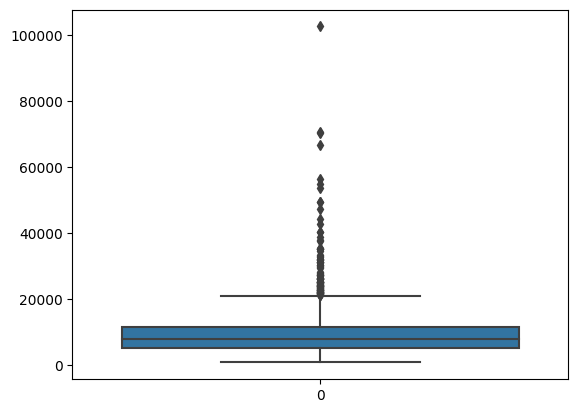

In [327]:
# Boxplot com o valor de remuneração média das empresas
sns.boxplot(df_final_clean['valor_remuneracao_media'])

In [328]:
# Identificação dos ids das empresas outliers
print(np.where(df_final_clean['valor_remuneracao_media']>20000))

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112]),)


In [329]:
# Identificação das empresas outliers pelo z score
z = np.abs(stats.zscore(df_final_clean['valor_remuneracao_media']))
threshold = 2

print(np.where(z > 2))

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111]),)


In [330]:
# IQR
Q1 = np.percentile(df_final_clean['valor_remuneracao_media'], 25, method='midpoint')
Q3 = np.percentile(df_final_clean['valor_remuneracao_media'], 75, method='midpoint')
IQR = Q3 - Q1

lower = Q1 - 1.5*IQR
upper = Q3 + 1.5*IQR

In [331]:
upper_array = np.where(df_final_clean['valor_remuneracao_media']>=upper)[0]
lower_array = np.where(df_final_clean['valor_remuneracao_media']<=lower)[0]

In [332]:
df_final_clean.drop(index=upper_array, inplace=True)
df_final_clean.drop(index=lower_array, inplace=True)

In [333]:
# Print do datafrmae com apenas as empresas que não são outliers em termos de valor de remuneração média
print (df_final_clean)

     cnae_2_subclasse  valor_remuneracao_media cbo_2002   sum_salary    id
93            6203100                 20790.82   212405  39386022.24    93
94            1042200                 20712.89   212405  39386022.24    94
95            1042200                 20691.81   212405  39386022.24    95
96            1042200                 20687.05   212405  39386022.24    96
97            6120501                 20657.34   212405  39386022.24    97
...               ...                      ...      ...          ...   ...
4492          2229301                   750.67   212405  39386022.24  4492
4493          2229301                   750.67   212405  39386022.24  4493
4494          6202300                   725.81   212405  39386022.24  4494
4495          6203100                   712.11   212405  39386022.24  4495
4496          4399101                   706.67   212405  39386022.24  4496

[4404 rows x 5 columns]


In [334]:
# Obtenção de dataframe apenas com as empresas que são outliers
df_outlier = df_total_cbo_filter_pd[~df_total_cbo_filter_pd['id'].isin(df_final_clean['id'])]

In [335]:
# Conversão do dataframe pandas para dataframe spark
df_outlier_sp = spark.createDataFrame(df_outlier)

/content/spark-3.3.2-bin-hadoop3/python/pyspark/sql/pandas/conversion.py:474: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
/content/spark-3.3.2-bin-hadoop3/python/pyspark/sql/pandas/conversion.py:486: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


In [336]:
df_outlier_sp.toPandas()

,cnae_2_subclasse,valor_remuneracao_media,cbo_2002,sum_salary,id
0,6203100,102595.57,212405,39386022.24,0
1,6203100,70445.37,212405,39386022.24,1
2,6203100,70342.47,212405,39386022.24,2
3,6203100,66546.25,212405,39386022.24,3
4,6202300,56255.90,212405,39386022.24,4
...,...,...,...,...,...
88,1042200,21613.82,212405,39386022.24,88
89,6203100,21415.14,212405,39386022.24,89
90,4912403,21315.28,212405,39386022.24,90
91,6203100,21302.94,212405,39386022.24,91


# Identificação das empresas que possivelmente realizaram preenchimento errado, levando em conta o valor médio de remuneração por CNAE

In [337]:
# Agrupamento por CNAE, trazendo a média de remuneração das empresas pertencentes
df_total_cbo_filter_md = df_total_cbo_filter.groupBy("cnae_2_subclasse")\
    .agg(avg(col("valor_remuneracao_media")).alias("media_clean")\
     ).orderBy(col("media_clean").desc())


In [338]:
df_total_cbo_filter_md.toPandas()

,cnae_2_subclasse,media_clean
0,6190602,25904.160000
1,2759799,23200.000000
2,2862300,21631.030000
3,6120599,21626.360000
4,1042200,19323.362727
...,...,...
148,4322301,1598.920000
149,1093701,1594.990000
150,2449199,1583.330000
151,2349499,1250.020000


In [348]:
# Obtenção do campo proporção que trará quantas vezes o valor da empresa é maior que a média de seu respectivo CNAE
df_cnae_outlier_full = df_outlier_sp.join(df_total_cbo_filter_md,'cnae_2_subclasse','Left')\
        .withColumn("proporcao",col("valor_remuneracao_media")/col("media_clean")).orderBy(col("proporcao").desc())

In [349]:
df_cnae_outlier_full.toPandas()

,cnae_2_subclasse,valor_remuneracao_media,cbo_2002,sum_salary,id,media_clean,proporcao
0,6203100,102595.57,212405,39386022.24,0,8668.569905,11.835351
1,6203100,70445.37,212405,39386022.24,1,8668.569905,8.126527
2,6203100,70342.47,212405,39386022.24,2,8668.569905,8.114657
3,6203100,66546.25,212405,39386022.24,3,8668.569905,7.676728
4,6202300,56255.90,212405,39386022.24,4,7874.995826,7.143610
...,...,...,...,...,...,...,...
88,1042200,21613.82,212405,39386022.24,88,19323.362727,1.118533
89,2862300,21631.03,212405,39386022.24,86,21631.030000,1.000000
90,6120599,21626.36,212405,39386022.24,87,21626.360000,1.000000
91,2759799,23200.00,212405,39386022.24,71,23200.000000,1.000000


In [352]:
# Escrevendo o dataframe na saída

df_cnae_outlier_full\
.coalesce(1)\
.write\
.format("csv")\
.mode("overwrite")\
.save(path_cbo_top_outliers)

In [353]:
# Conversão para dataframe pandas para aplicação da análise de outlier
df_cnae_outlier_full = df_cnae_outlier_full.toPandas()

<Axes: >

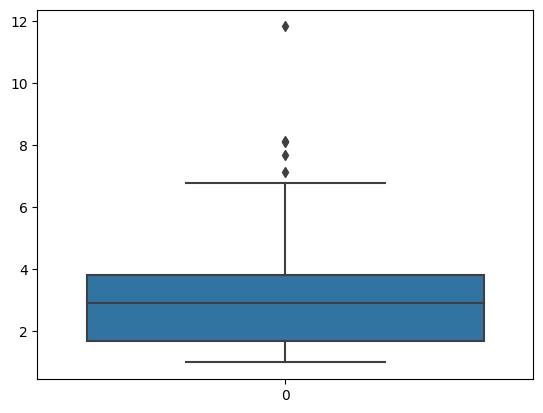

In [354]:
sns.boxplot(df_cnae_outlier_full['proporcao'])

In [355]:
# Identificação dos outliers em questão de proporção representativa no respectivo CNAE
print(np.where(df_cnae_outlier_full['proporcao']>7))

(array([0, 1, 2, 3, 4]),)


# Resumo da análise

- As empresas de índice 0 a 4 possuem uma proporção maior do que 7 vezes a média de seu respectivo CNAE, sendo assim, é aconselhável averiguar se houve preenchimento equivocado por parte dessas empresas.